### 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 패키지 Import

In [2]:
# !pip install tensorflow==2.4.1
# !pip install numpy==1.19.2
import tensorflow as tf
import numpy as np
print(tf.__version__, np.__version__)

2.9.2 1.21.6


In [3]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten,BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from tqdm import tqdm
from numpy import fromfile
import os
from os import listdir
from os.path import isfile, join

로컬로부터 데이터를 불러오는 코드

In [5]:
def prep_data_pretained(name, fluid, pressure, meta=False, pinhole=1, ch_loc={'ch1':2500, 'ch2':1600, 'ch3':0}, train=True, seconds=[x for x in range(120,360)]):
  n_total_feature = 19*3+4*(meta)
  n_feature = 19*3
  n_channel = 3
  output = []
  os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_concat")
  load = np.load(f"{name}_X.npy")
  load = load[seconds]
  if meta:
    output = []
    for sec in load:
      temp = sec
      meta = np.array([ch_loc['ch1'], ch_loc['ch2'], ch_loc['ch3'], fluid, fluid, fluid, pressure, pressure, pressure, pinhole, pinhole, pinhole]).reshape(-1, 3)
      temp = np.concatenate((temp, meta), axis=0)
      output.append(temp)
    output = np.asarray(output).reshape(-1, n_total_feature, n_channel)
  else:
    output = load
  return output

leakage dectection을 통해 'Y'인 로우만을 train set으로 사용<br>
이 때 feature는 leakage detection과 동일하게 원본 signal값에 대해 preprocessing(FFT, FE)를 적용하여 얻은 57개 feature를 사용<br> meta data는 이용하지 않았다.

In [6]:
names = ["Water_13Bar", "Water_18Bar", "Gas_13Bar", "Gas_18Bar"]
for name in names:
  if name=="Water_13Bar":
    temp = prep_data_pretained(name, 0, 13)
  elif name=="Water_18Bar":
    temp = prep_data_pretained(name, 0, 18)
  elif name=="Gas_13Bar":
    temp = prep_data_pretained(name, 1, 13)
  else:
    temp = prep_data_pretained(name, 1, 18)
  os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_localization")
  np.save(f"{name}_X.npy",temp)

In [7]:
# os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_localization")
# l = []
# names = ["Water_13Bar_X.npy", "Water_18Bar_X.npy", "Gas_13Bar_X.npy", "Gas_18Bar_X.npy"]
# for name in names:
#   l.append(np.load(name, allow_pickle=True))
# train_X = np.asarray(l)
# np.save("train_X.npy", train_X)

정답 데이터 작성, 이 때 정답 0.32는 전체 길이(2500)에 대해 leakage가 일어난 포인트(800)의 3채널로부터의 상대적인 위치 800/2500으로 정의

In [8]:
train_y = np.array([0.32]*960).reshape(4,-1)
np.save("train_y.npy", train_y)

In [9]:
os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_localization")
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [10]:
print(train_X.shape, train_y.shape)

(4, 240, 57, 3) (4, 240)


In [11]:
verbose, epochs, batch_size = True, 150, 30

leakage detection과 동일하게 잠재 feature extracting을 위한 CNN Layer, 정답 값 추출을 위한 LSTM Layer로 구성됨

In [12]:
# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(57, 3)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam', metrics="mape")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 32)            3104      
                                                                 
 dropout (Dropout)           (None, 55, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [13]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 60, mode = 'auto')

In [14]:
history_list = []
for i in range(4):
  history_list.append(model.fit(train_X[i], train_y[i], validation_split=0.2, shuffle=True,
                          epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping]))

Epoch 1/150
7/7 [==============================] - 8s 324ms/step - loss: 0.5436 - mape: 185.9205 - val_loss: 0.3800 - val_mape: 191.7192
Epoch 2/150
7/7 [==============================] - 1s 79ms/step - loss: 0.2552 - mape: 127.4240 - val_loss: 0.2633 - val_mape: 159.2025
Epoch 3/150
7/7 [==============================] - 0s 66ms/step - loss: 0.1964 - mape: 112.8694 - val_loss: 0.0045 - val_mape: 17.6409
Epoch 4/150
7/7 [==============================] - 1s 77ms/step - loss: 0.1639 - mape: 104.4904 - val_loss: 0.0094 - val_mape: 25.7095
Epoch 5/150
7/7 [==============================] - 0s 34ms/step - loss: 0.1264 - mape: 90.2342 - val_loss: 0.0296 - val_mape: 43.7669
Epoch 6/150
7/7 [==============================] - 0s 36ms/step - loss: 0.0767 - mape: 67.1884 - val_loss: 0.0252 - val_mape: 41.4781
Epoch 7/150
7/7 [==============================] - 0s 38ms/step - loss: 0.0814 - mape: 70.7647 - val_loss: 0.0017 - val_mape: 10.4006
Epoch 8/150
7/7 [==============================] - 0s 3

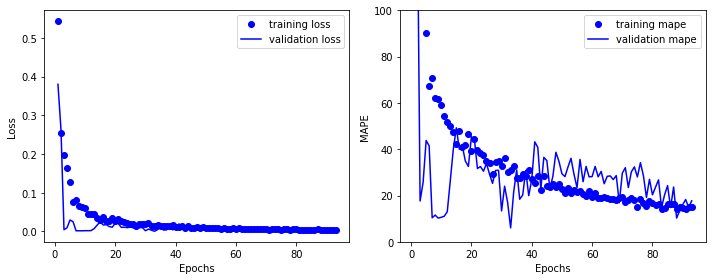

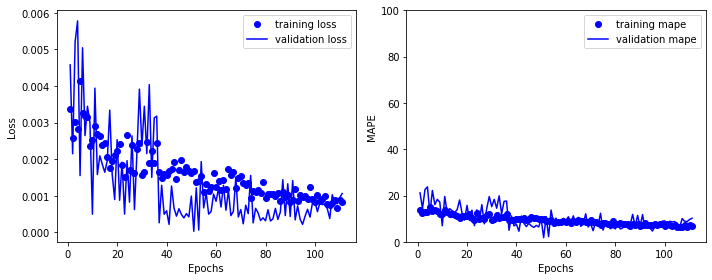

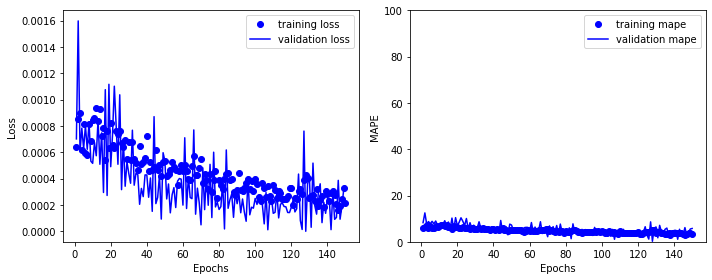

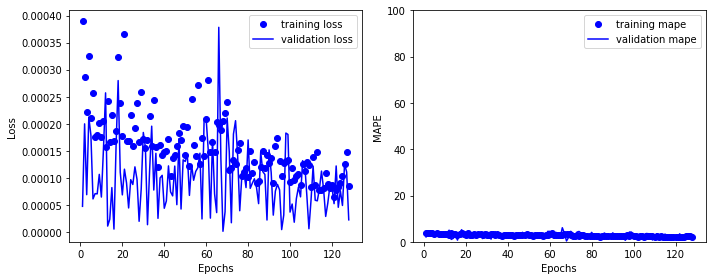

In [16]:
import matplotlib.pyplot as plt

for history in history_list:
  history_dict= history.history

  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  accuracy = history_dict['mape']
  val_accuracy = history_dict['val_mape']

  epochs = range(1, len(loss)+1)

  plt.figure(figsize=(10, 4))

  plt.subplot(121)


  plt.plot(epochs, loss, 'bo',label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss') 
  plt.legend()

  plt.subplot(122)


  plt.plot(epochs, accuracy, 'bo',label='training mape')
  plt.plot(epochs, val_accuracy, 'b', label='validation mape')
  plt.xlabel('Epochs')
  plt.ylabel('MAPE')
  plt.ylim((0, 100))
  plt.legend()

  plt.tight_layout()
  plt.show()

test set에 대해 preprocessing(FFT, FE)가 적용된 파일을 로컬로부터 불러옴

In [17]:
os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_localization")
ld_dataset1 = np.load("dataset1_bool.npy").reshape(-1,)
ld_dataset2 = np.load("dataset2_bool.npy").reshape(-1,)
ld_dataset3 = np.load("dataset3_bool.npy").reshape(-1,)

Leakage detection을 통해 'Y'였던 로우만을 추출

In [18]:
temp = []
for i, x in enumerate(ld_dataset1):
  if x:
    temp.append(i)
ld_dataset1 = temp
temp = []
for i, x in enumerate(ld_dataset2):
  if x:
    temp.append(i)
ld_dataset2 = temp
temp = []
for i, x in enumerate(ld_dataset3):
  if x:
    temp.append(i)
ld_dataset3 = temp

In [19]:
names = ["Dataset1", "Dataset2", "Dataset3"]
for name in names:
  if name == "Dataset1":
    temp = prep_data_pretained(name=name, fluid=0, pressure=7, pinhole=1, seconds=ld_dataset1) #Water:0, Gas:1
  elif name == "Dataset2":
    temp = prep_data_pretained(name=name, fluid=0, pressure=7, pinhole=1, seconds=ld_dataset2)
  else:
    temp = prep_data_pretained(name=name, fluid=0, pressure=7, pinhole=1, seconds=ld_dataset3)
  os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_localization")
  np.save(f"{name}_X.npy",temp)
  print(temp.shape)

(196, 57, 3)
(156, 57, 3)
(34, 57, 3)


In [20]:
os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_localization")
dataset1_X = np.load("Dataset1_X.npy")
dataset2_X = np.load("Dataset2_X.npy")
dataset3_X = np.load("Dataset3_X.npy")

In [21]:
dataset2_X.shape

(156, 57, 3)

모델에 test set 적용 

In [22]:
preds1 = model.predict(dataset1_X)
preds2 = model.predict(dataset2_X)
preds3 = model.predict(dataset3_X)

2/2 [==============================] - 0s 13ms/step


In [26]:
preds1

array([[0.31558475],
       [0.31567198],
       [0.31583053],
       [0.31524414],
       [0.31557405],
       [0.31504214],
       [0.31526586],
       [0.31556633],
       [0.31556615],
       [0.31551528],
       [0.3155076 ],
       [0.315408  ],
       [0.31558204],
       [0.31559125],
       [0.3155361 ],
       [0.31555122],
       [0.31521833],
       [0.31558365],
       [0.3156087 ],
       [0.31556946],
       [0.31528598],
       [0.31549507],
       [0.31544563],
       [0.31559244],
       [0.3150536 ],
       [0.31545994],
       [0.31558335],
       [0.3155701 ],
       [0.315574  ],
       [0.3154508 ],
       [0.31558672],
       [0.31557107],
       [0.31558347],
       [0.31560308],
       [0.31533492],
       [0.31557164],
       [0.31552535],
       [0.31555414],
       [0.31557617],
       [0.31558478],
       [0.31539643],
       [0.3155487 ],
       [0.31562042],
       [0.3155835 ],
       [0.31525218],
       [0.31553784],
       [0.3155493 ],
       [0.315

메타 데이터인 channel의 위치를 이용하여 정답 값 구해냄, 이 때 dataset3은 3채널의 위치가 120000이므로 다음과 같이 적용 

In [27]:
preds1 = preds1*2500
preds2 = preds2*2500
preds3 = 120000 - preds3*120000

submission을 위해 로컬 저장

In [31]:
os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/submission")
np.save("dataset_1_loacalization.npy", preds1)
np.save("dataset_2_loacalization.npy", preds2)
np.save("dataset_3_loacalization.npy", preds3)

In [32]:
model.save('/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/submission/localization.h5')